Read the readme.md file first.
EDA:

In [1]:
import pandas as pd
import numpy as np
#plotting and statistical packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
#display graphs in notebook
%matplotlib inline
#displays a load bar for tracking loop time processing
from tqdm import tqdm


In [2]:
#lets load the first chunk of data and look around
instacart_file=pd.read_csv('Data/orders.csv')
df_orders=pd.DataFrame(instacart_file,)
df_orders.head(12)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [3]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


The eval_set has broken data down to a prior data set, a training set and a test set. (see data readme.md for more details data (column meaings, NaN useage, and data useage terms and conditions).

Lets segregate our data in order to keep the test data fresh and uncontaminated. We'll explore around in the prior data set to get an idea about the data. Then look at setting up the mechanics for the recommendor.

In [4]:
df_prior_set=df_orders[df_orders['eval_set']=='prior']
df_prior_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
df_train_set=df_orders[df_orders['eval_set']=='train']
df_train_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0


In [6]:
df_test_set=df_orders[df_orders['eval_set']=='test']
df_test_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [7]:
df_prior_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3421081
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 196.2+ MB


In [8]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131209 entries, 10 to 3421082
Data columns (total 7 columns):
order_id                  131209 non-null int64
user_id                   131209 non-null int64
eval_set                  131209 non-null object
order_number              131209 non-null int64
order_dow                 131209 non-null int64
order_hour_of_day         131209 non-null int64
days_since_prior_order    131209 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 8.0+ MB


In [9]:
df_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 38 to 3421068
Data columns (total 7 columns):
order_id                  75000 non-null int64
user_id                   75000 non-null int64
eval_set                  75000 non-null object
order_number              75000 non-null int64
order_dow                 75000 non-null int64
order_hour_of_day         75000 non-null int64
days_since_prior_order    75000 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 4.6+ MB


In [10]:
# non-null is limited to the days_since_prior_order
for col in df_prior_set.columns:
    print(df_prior_set[col].isnull().any())

False
False
False
False
False
False
True


Lets look at how users order. First by seeing how many orders each user has in the data set.

In [11]:
#group prior data by user_id
dfp_gp_user=df_prior_set.groupby('user_id')

In [12]:
#create pandas series for number of orders by user and plot
user_order_count=dfp_gp_user.order_number.max()
user_order_count.head()

user_id
1    10
2    14
3    12
4     5
5     4
Name: order_number, dtype: int64

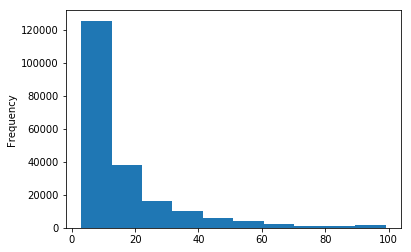

In [13]:
user_order_count.plot(kind='hist')

Looking at order counts by users we wee that most users order between 1 and 20 orders.

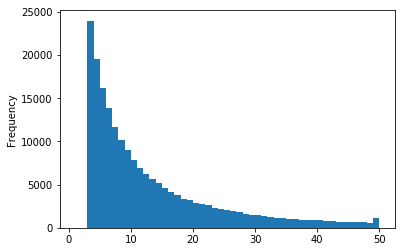

In [14]:
# a closer look at orders between 0 to 50
user_order_count.plot(kind='hist',bins=np.linspace(1,50))

In [15]:
user_order_count.median()

9.0

In [16]:
user_order_count.describe()

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_number, dtype: float64

206 thousand orders. A range for users orders between 3 and 99 orders. An mean of 16 orders per user and a median of 9 orders. 

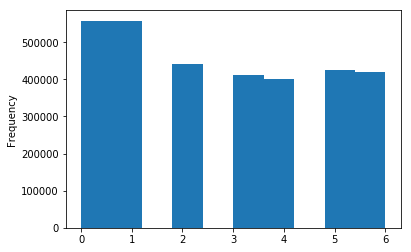

In [17]:
df_prior_set.order_dow.plot(kind='hist')

Lets look at Orders by Day of the Week. What day are people shopping?

Text(0.5,0,u'Orders by Day of the Week')

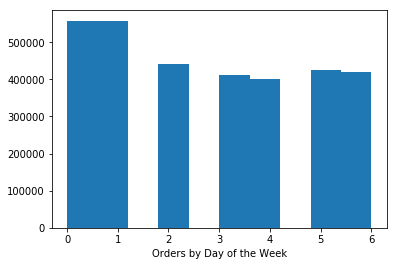

In [18]:
plt.hist(df_prior_set.order_dow)
plt.xlabel("Orders by Day of the Week")

The data set is not clear on which day zero is. The beginning of Instacart week does see the most 
orders with he rest of the week being closely similiar. (It would be a logical assumption that 0 
and 1 represent the weekend, however, we do not know this.)


Lets look at hour of the day. When are most orders received?

Text(0.5,0,u'Orders by Hour of Day')

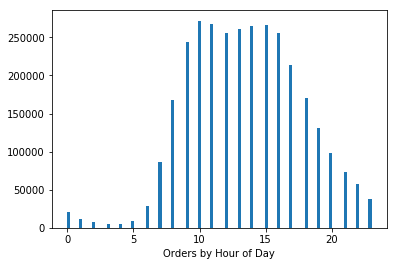

In [19]:
plt.hist(df_prior_set.order_hour_of_day, bins=100)
plt.xlabel('Orders by Hour of Day')


Hour of day indicates most orders between 8am and 8pm which makes sense. 

Looking at Days since prior order:

Text(0.5,0,u'Days since prior order')

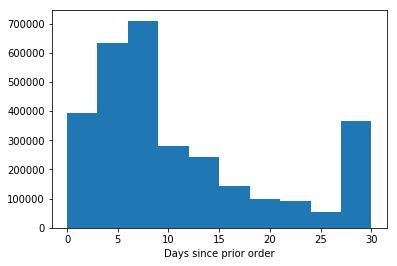

In [20]:
plt.hist(df_prior_set.days_since_prior_order.dropna(),)
plt.xlabel("Days since prior order")

It looks like most orders are followed by another order with in the week. 

The previous data set did not have any describtion on the contents of the order. That information is contained in order_products csv files. Lets explore that for a minute. 

In [21]:
#lets load another chunk of data and look around
instacart_file2=pd.read_csv('Data/order_products__prior.csv')
df_products_prior=pd.DataFrame(instacart_file2,)
df_products_prior.head(12)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


We have each order uniquely identified by order id, each product uniquely identified by product_id, the order in which each product was added to the cart and if the product/item was a reorder.

In [22]:
df_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


Lets explore reorders

In [23]:
#group by order_id for reorders
reorders_by_order=df_products_prior['reordered'].groupby(df_products_prior['order_id']).sum()

In [24]:
reorders_by_order.describe()


count    3.214874e+06
mean     5.949389e+00
std      5.842059e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.300000e+02
Name: reordered, dtype: float64

In [25]:
reorders_by_order.median()

4.0

Reorders per order range from none to 130. Order average almost 6 reorders and a median of 4 reorders.

Text(0.5,0,u'reorders by order')

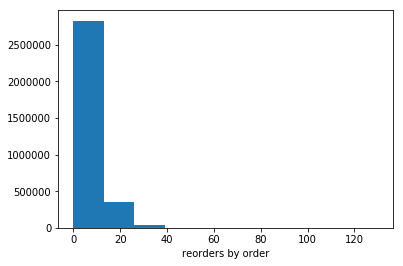

In [26]:
plt.hist(reorders_by_order)
plt.xlabel("reorders by order")


The 130 reorder seems to appear to be an outlier. Most reorders are below 40 with the majority below 20.

Lets look at what portion of the order is reorders.

In [27]:
#count reorders by grouping by order_id on the reordered column
items_in_order=df_products_prior['reordered'].groupby(df_products_prior['order_id']).count()

([<matplotlib.patches.Wedge at 0x10cdc9250>,
 [Text(0.305886,1.05661,u'non-reorders'),
  Text(-0.305886,-1.05661,u'reorders')],
 [Text(0.166847,0.576335,u'41.0%'), Text(-0.166847,-0.576335,u'59.0%')])

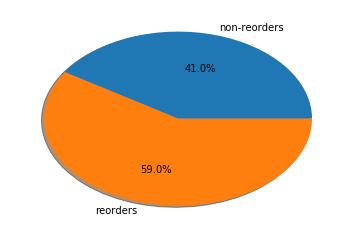

In [28]:
#plot the portion
plt.pie([(items_in_order.sum()-reorders_by_order.sum()),reorders_by_order.sum()],labels=['non-reorders','reorders'],autopct='%1.1f%%', shadow=True)

In [29]:
print(reorders_by_order.sum(),":reordered items",items_in_order.sum(),":items ordered")

(19126536L, ':reordered items', 32434489L, ':items ordered')


Most orders contian around 60% reorders.

In [30]:
print( type(items_in_order),type(reorders_by_order))

(<class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>)


In [154]:
#dataframe to easily see portion of reorders
df_order_totals=pd.concat([items_in_order,reorders_by_order], axis=1, 
                          join='inner',keys=['items_n_order','reorders_n_order'])

df_order_totals['pct_reorders']=df_order_totals.reorders_n_order/df_order_totals.items_n_order
df_order_totals.head()

,items_n_order,reorders_n_order,pct_reorders
order_id,,,
2,9,6,0.666667
3,8,8,1.000000
4,13,12,0.923077
5,26,21,0.807692
6,3,0,0.000000


In [155]:
reorders_n_orders=df_order_totals.groupby('reorders_n_order').count()
reorders_n_orders.rename(columns={'items_n_order':'freq','pct_reorders':'reorders per order by count'},inplace=True)
reorders_n_orders.sort_values('reorders per order by count',ascending=False).head(10)

,freq,reorders per order by count
reorders_n_order,,
0,388513,388513
2,330770,330770
1,327898,327898
3,312493,312493
4,281704,281704
5,246626,246626
6,211744,211744
7,180083,180083
8,152229,152229


Not to surprising orders with 0 reorders are the most common. The only intersting point people seem to reorder 2 items more often then just one item. The likelihood of reorders diminshes with increasing order size after that.  

In [167]:
high_pct_reorders=df_order_totals.groupby(pd.cut(df_order_totals["pct_reorders"], np.arange(0, 1.0, 0.1))).sum()
high_pct_reorders["order count per %"]=df_order_totals['items_n_order'].groupby(pd.cut(df_order_totals["pct_reorders"], np.arange(0, 1.0, 0.1))).count()
high_pct_reorders["pct_reorders"]=high_pct_reorders.reorders_n_order/high_pct_reorders['items_n_order']
high_pct_reorders.rename(columns={'items_n_order':' total_items_n_bracket','reorders_n_order':'total_reorders_n_bracket'},inplace=True)
high_pct_reorders.sort_values('order count per %',ascending=False)

,total_items_n_bracket,total_reorders_n_bracket,pct_reorders,order count per %
pct_reorders,,,,
"(0.7, 0.8]",4059070,3071363,0.756667,347881
"(0.4, 0.5]",3172981,1482753,0.467306,316473
"(0.8, 0.9]",3829141,3277139,0.855842,293627
"(0.6, 0.7]",3369727,2212437,0.656563,284693
"(0.3, 0.4]",2447176,875706,0.357843,229923
"(0.5, 0.6]",2761974,1561753,0.565448,213822
"(0.2, 0.3]",1787884,461661,0.258216,155163
"(0.1, 0.2]",1511068,240899,0.159423,141139
"(0.0, 0.1]",532566,40389,0.075838,35263


The above table show Orders with 70% to 80% reorders had the highest volume.

In [33]:
products_in_order=df_products_prior['order_id'].groupby(df_products_prior['product_id']).nunique()
products_in_order=products_in_order.sort_values(ascending=False)
products_in_order.head(10)

product_id
24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
47766    176815
47626    152657
16797    142951
26209    140627
27845    137905
Name: order_id, dtype: int64

In [34]:
#lets load the product names
instacart_products=pd.read_csv('Data/products.csv')
df_ic_prod=pd.DataFrame(instacart_products,)
df_ic_prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [35]:
products_in_order=pd.DataFrame(products_in_order)
products_in_order.rename(columns={'order_id':'purchases'},inplace=True)
products_in_order.head()

,purchases
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [36]:
products_in_order=pd.merge(df_ic_prod,products_in_order, how= 'outer',left_on="product_id" , right_index= True)


In [37]:
products_in_order.head()

,product_id,product_name,aisle_id,department_id,purchases
0,1,Chocolate Sandwich Cookies,61,19,1852.0
1,2,All-Seasons Salt,104,13,90.0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0
4,5,Green Chile Anytime Sauce,5,13,15.0


In [38]:
top_sellers=products_in_order.set_index('product_name')


In [39]:
top_sellers=top_sellers.sort_values(by='purchases',ascending=False).head(15)
top_sellers


,product_id,aisle_id,department_id,purchases
product_name,,,,
Banana,24852,24,4,472565.0
Bag of Organic Bananas,13176,24,4,379450.0
Organic Strawberries,21137,24,4,264683.0
Organic Baby Spinach,21903,123,4,241921.0
Organic Hass Avocado,47209,24,4,213584.0
Organic Avocado,47766,24,4,176815.0
Large Lemon,47626,24,4,152657.0
Strawberries,16797,24,4,142951.0
Limes,26209,24,4,140627.0


Text(0.5,1,u'best sellers')

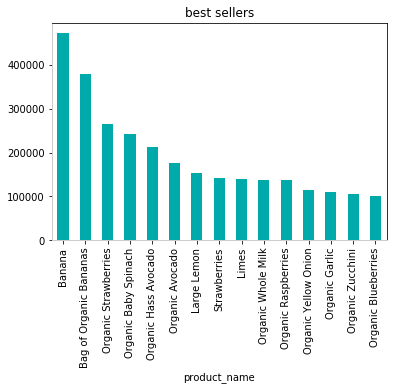

In [61]:

ax = top_sellers.purchases.plot(kind='bar',facecolor='#00AAAA')

ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.set_title('best sellers')


Lets see which products get reordered the most.

In [41]:
products_reordered=df_products_prior['reordered'].groupby(df_products_prior['product_id']).sum()
products_reordered=products_reordered.sort_values(ascending=False)
products_reordered.head(15)

product_id
24852    398609
13176    315913
21137    205845
21903    186884
47209    170131
47766    134044
27845    114510
47626    106255
27966    105409
16797     99802
26209     95768
22935     79072
24964     74663
45007     72165
49683     67313
Name: reordered, dtype: int64

In [42]:
products_reordered=pd.DataFrame(products_reordered)

In [43]:
products_reordered.head()

,reordered
product_id,
24852,398609
13176,315913
21137,205845
21903,186884
47209,170131


In [48]:
products_in_order=pd.merge(products_in_order,products_reordered, how= 'outer',left_on="product_id", right_index= True)
products_in_order.head()


,product_id,product_name,aisle_id,department_id,purchases,reordered
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0
1,2,All-Seasons Salt,104,13,90.0,12.0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0


In [50]:
top_reorders=products_in_order.set_index('product_name')
top_reorders=top_reorders.sort_values(by='reordered',ascending=False).head(15)
top_reorders


,product_id,aisle_id,department_id,purchases,reordered
product_name,,,,,
Banana,24852,24,4,472565.0,398609.0
Bag of Organic Bananas,13176,24,4,379450.0,315913.0
Organic Strawberries,21137,24,4,264683.0,205845.0
Organic Baby Spinach,21903,123,4,241921.0,186884.0
Organic Hass Avocado,47209,24,4,213584.0,170131.0
Organic Avocado,47766,24,4,176815.0,134044.0
Organic Whole Milk,27845,84,16,137905.0,114510.0
Large Lemon,47626,24,4,152657.0,106255.0
Organic Raspberries,27966,123,4,137057.0,105409.0


Text(0.5,1,u'top reorders')

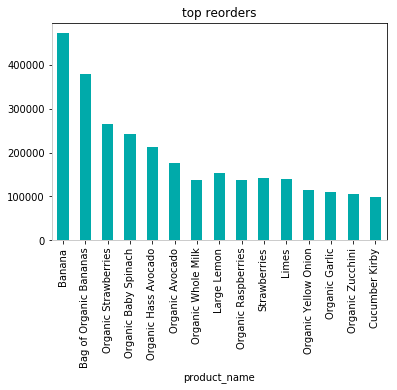

In [64]:

ax = top_reorders.purchases.plot(kind='bar',facecolor='#00AAAA')

ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.set_title('top reorders')


Lets see what product has the highest chance of being reordered. We will use the empirecal data of reorders divided by purchases(oppurtunity to reorder) has the probability of reorder.

In [75]:
#calculate portion of reorders and assign to new column
products_in_order['portion']=products_in_order.reordered/products_in_order.purchases
products_in_order.head()

,product_id,product_name,aisle_id,department_id,purchases,reordered,portion
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


In [77]:
#set product name as index
top_sellers=products_in_order.set_index('product_name')
top_sellers=top_sellers.sort_values(by='purchases',ascending=False).head(15)
top_sellers

,product_id,aisle_id,department_id,purchases,reordered,portion
product_name,,,,,,
Banana,24852,24,4,472565.0,398609.0,0.843501
Bag of Organic Bananas,13176,24,4,379450.0,315913.0,0.832555
Organic Strawberries,21137,24,4,264683.0,205845.0,0.777704
Organic Baby Spinach,21903,123,4,241921.0,186884.0,0.772500
Organic Hass Avocado,47209,24,4,213584.0,170131.0,0.796553
Organic Avocado,47766,24,4,176815.0,134044.0,0.758103
Large Lemon,47626,24,4,152657.0,106255.0,0.696038
Strawberries,16797,24,4,142951.0,99802.0,0.698155
Limes,26209,24,4,140627.0,95768.0,0.681007


In [78]:
top_portion=products_in_order.set_index('product_name')
top_portion=top_portion.sort_values(by='purchases',ascending=False).head(15)
top_portion

,product_id,aisle_id,department_id,purchases,reordered,portion
product_name,,,,,,
Banana,24852,24,4,472565.0,398609.0,0.843501
Bag of Organic Bananas,13176,24,4,379450.0,315913.0,0.832555
Organic Strawberries,21137,24,4,264683.0,205845.0,0.777704
Organic Baby Spinach,21903,123,4,241921.0,186884.0,0.772500
Organic Hass Avocado,47209,24,4,213584.0,170131.0,0.796553
Organic Avocado,47766,24,4,176815.0,134044.0,0.758103
Large Lemon,47626,24,4,152657.0,106255.0,0.696038
Strawberries,16797,24,4,142951.0,99802.0,0.698155
Limes,26209,24,4,140627.0,95768.0,0.681007


Text(0.5,1,u'top probability reorders')

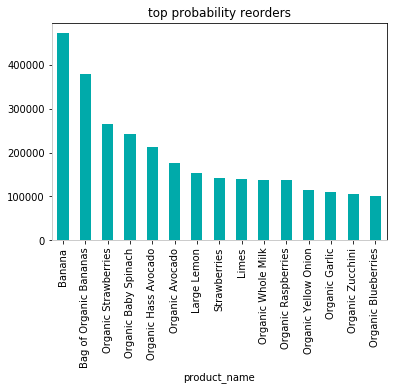

In [80]:
#plot portion column
ax = top_portion.purchases.plot(kind='bar',facecolor='#00AAAA')

ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.set_title('top probability of reorder')



In [81]:
df_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
